In [2]:
import os

import imageio
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# import skimage, skimage.io

%matplotlib inline

In [3]:
plt.rcParams['figure.dpi'] = 100

In [80]:
def blank_image(
    shape: tuple[int]=(600, 800, 4),
    rgba: tuple[int]=(255, 255, 255, 0)
    ) -> np.ndarray:
    """Returns a blank image, of size defined by shape and background color rgb."""
    return np.ones(shape, dtype=np.float) * np.array(rgba) / 255.

In [92]:
def display(img: np.ndarray, colorbar: bool=False):
    """Displays an image."""
    plt.figure(figsize=(10, 10))
    if len(img.shape) == 2:
        i = skimage.io.imshow(img, cmap='gray')
    else:
        i = skimage.io.imshow(img)
    if colorbar:
        plt.colorbar(i, shrink=0.5, label='depth')
    plt.tight_layout()
    return i

In [82]:
def make_pattern(shape: tuple[int]=(16, 16), levels: int=64):
    """Creates a pattern from gray values."""
    return np.random.randint(0, levels - 1, shape) / levels

In [83]:
def create_circular_depthmap(shape: tuple[int]=(600, 800), center: np.ndarray|None=None, radius: int=100) -> np.ndarray:
    """Creates a circular depthmap, centered on the image."""
    depthmap = np.zeros(shape, dtype=np.float)
    r = np.arange(depthmap.shape[0])
    c = np.arange(depthmap.shape[1])
    R, C = np.meshgrid(r, c, indexing='ij')
    if center is None:
        center = np.array([r.max() / 2, c.max() / 2])
    d = np.sqrt((R - center[0])**2 + (C - center[1])**2)
    depthmap += (d < radius)
    return depthmap 

In [84]:
def normalize(depthmap: np.ndarray) -> np.ndarray:
    """Normalizes values of depthmap to [0, 1] range."""
    if depthmap.max() > depthmap.min():
        return (depthmap - depthmap.min()) / (depthmap.max() - depthmap.min())
    else:
        return depthmap

In [85]:
def make_autostereogram(depthmap: np.ndarray, pattern: np.ndarray, shift_amplitude: float=0.1, invert: bool=False) -> np.ndarray:
    """Creates an autostereogram from depthmap and pattern."""
    depthmap = normalize(depthmap)
    if invert:
        depthmap = 1 - depthmap
    autostereogram = np.zeros_like(depthmap, dtype=pattern.dtype)
    for r in np.arange(autostereogram.shape[0]):
        for c in np.arange(autostereogram.shape[1]):
            if c < pattern.shape[1]:
                autostereogram[r, c] = pattern[r % pattern.shape[0], c]
            else:
                shift = int(depthmap[r, c] * shift_amplitude * pattern.shape[1])
                autostereogram[r, c] = autostereogram[r, c - pattern.shape[1] + shift]
    return autostereogram

In [86]:
pattern = make_pattern(shape=(128, 64))

In [87]:
depthmap = create_circular_depthmap(center=(150, 400), radius=30) + \
           create_circular_depthmap(center=(400, 400), radius=30)
depthmap = normalize(depthmap)

display(depthmap, colorbar=True)

C:\Users\fairy26\AppData\Local\Temp\ipykernel_25168\2106787598.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  depthmap = np.zeros(shape, dtype=np.float)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


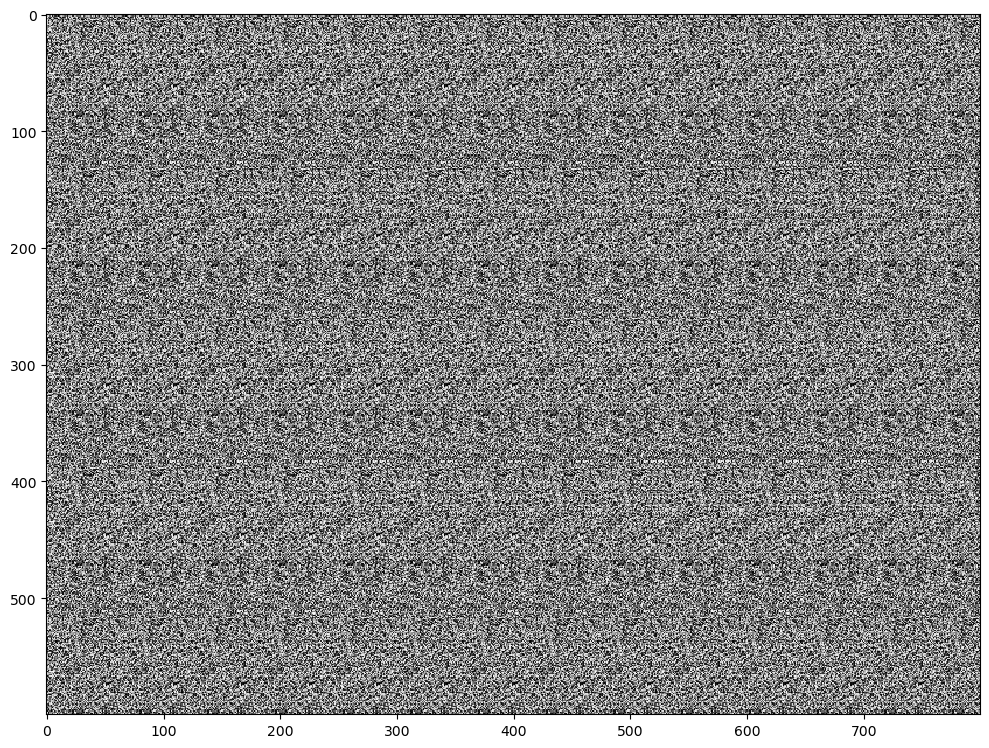

In [95]:
autostereogram = make_autostereogram(depthmap, pattern, invert=True)

# imageio.imwrite("立体視.png", autostereogram)
display(autostereogram)

# 左右に動くGIFを作る
- 参考
- https://towardsdatascience.com/basics-of-gifs-with-pythons-matplotlib-54dd544b6f30

In [89]:
# coordinates_lists = [[[300, 700, 290, 710],[300, 300, 700, 700]],
#                      [[300, 700, 310, 690],[300, 300, 700, 700]],
#                      [[300, 700, 290, 710],[300, 300, 700, 700]]]
coordinates_lists = [[[295, 705],[500, 500]],
                     [[305, 695],[500, 500]],
                     [[295, 705],[500, 500]]]
gif_name = 'movie' 
n_frames=100
marker_color='#2b2b2b' 
marker_size = 100

print('building plots...\n')
filenames = []
for index in np.arange(0, len(coordinates_lists)-1):
    
    # get current and next coordinates
    x = coordinates_lists[index][0]
    y = coordinates_lists[index][1]
    x1 = coordinates_lists[index+1][0]
    y1 = coordinates_lists[index+1][1]
    
    # calculate paths
    x_path = np.array(x1) - np.array(x)
    y_path = np.array(y1) - np.array(y)
    for i in np.arange(0, n_frames + 1):
        # calculate current position
        x_temp = (x + (x_path / n_frames) * i)
        y_temp = (y + (y_path / n_frames) * i)
        
        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw = dict(aspect="equal"))

        plt.scatter(x_temp, y_temp, c=marker_color, s=marker_size)
        plt.xlim(0,1000)
        plt.ylim(0,1000)
        
        ax.axis("off")
        
        filename = f'images/frame_{index}_{i}.png'
        filenames.append(filename)
        if (i == n_frames):
            for i in range(5):
                filenames.append(filename)
        
        plt.savefig(filename, dpi=96)
        plt.close()

print('creating gif...\n')
with imageio.get_writer(f'{gif_name}.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('gif complete...\n')

print('Removing Images...\n')
for filename in set(filenames):
    os.remove(filename)

print('done')

building plots...

creating gif...



C:\Users\fairy26\AppData\Local\Temp\ipykernel_25168\1615575233.py:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


gif complete...

Removing Images...

done


In [25]:
from pathlib import Path
from pprint import pprint
import random

from IPython.display import clear_output
import matplotlib.pyplot as plt

%matplotlib inline


def show_dots(index: int, delta_d: float, diameter: float) -> None:
    """立体視を描画する関数"""
    
    base_x1, base_x2 = 300, 700
    up_y, down_y = 700, 300
    
    xs = [base_x1-delta_d, base_x2+delta_d] + [base_x1, base_x2]    # 上段 + 下段
    ys = [up_y, up_y] + [down_y, down_y]
        
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw = dict(aspect="equal"))

    plt.scatter(xs, ys, c="k", s=diameter)
    plt.title(f"{delta_d = }, {diameter = }")
    plt.xlim(0,1000)
    plt.ylim(0,1000)

    ax.axis("off")

    plt.savefig(f'images/frame_{diameter}_{index}.png')
    plt.show()

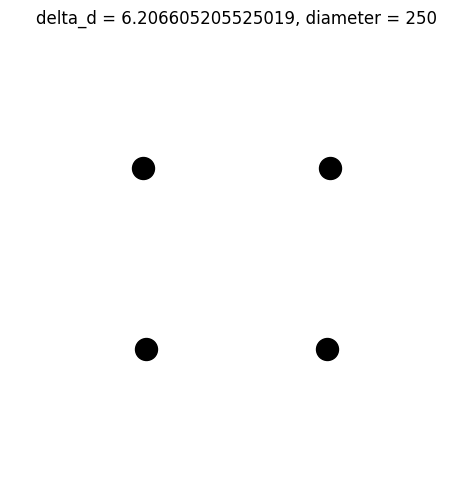

In [26]:
Path("images").mkdir(exist_ok=True)

# 実験
results = []
for diameter in range(50, 300, 50):
    for index in range(20):
        delta_d = random.uniform(-10, 10)
        show_dots(index, delta_d, diameter)
        
        instr = input("奥行きが異なる(1) or 奥行きが等しい(0): ")
        if instr == "exit":
            break
        
        results.append({
            "delta_d": delta_d,
            "diameter": diameter,
            "recognizable": (1 == int(instr))
            })
        
        clear_output(True)

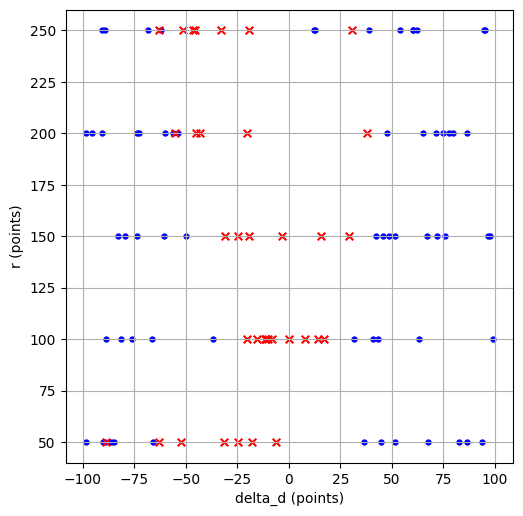

In [31]:
# 実験結果の表示
delta_ds_ok = []
delta_ds_ng = []
diameters_ok = []
diameters_ng = []
for result in results:
    if result["recognizable"]:
        delta_ds_ok.append(result["delta_d"]*10)    # 軸のスケールを統一するために10倍する
        diameters_ok.append(result["diameter"])
    else:
        delta_ds_ng.append(result["delta_d"]*10)
        diameters_ng.append(result["diameter"])
        

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw = dict(aspect="equal"))

plt.scatter(delta_ds_ok, diameters_ok, marker=".", c="b", s=50)
plt.scatter(delta_ds_ng, diameters_ng, marker="x", c="r", s=30)
plt.xlabel("delta_d (points)", fontsize=10)
plt.ylabel("r (points)", fontsize=10)
plt.grid(True)

plt.savefig(f'images/result.png')
plt.show()

# 以下は参考スクリプト

In [90]:
# import glob
# from PIL import Image

# import matplotlib.pyplot as plt
# import matplotlib.animation as animation

# folderName = "images"

# # 画像一覧を作る
# pattern = make_pattern(shape=(128, 64))
# depthmap = create_circular_depthmap(center=(150, 200), radius=30) + \
#            create_circular_depthmap(center=(150, 600), radius=30) + \
#            create_circular_depthmap(center=(400, 250), radius=30) + \
#            create_circular_depthmap(center=(400, 550), radius=30)
# depthmap = normalize(depthmap)
# autostereogram = make_autostereogram(depthmap, pattern, invert=True)

# #画像ファイルの一覧を取得
# picList = glob.glob(folderName + "\*.png")

# #figオブジェクトを作る
# fig = plt.figure()

# #空のリストを作る
# ims = []

# #画像ファイルを順々に読み込んでいく
# for i in range(len(picList)):
    
#     #1枚1枚のグラフを描き、appendしていく
#     tmp = Image.open(picList[i])
#     ims.append(plt.imshow(tmp))     

# #アニメーション作成    
# ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000)
# ani.save("test.gif")

C:\Users\fairy26\AppData\Local\Temp\ipykernel_25168\2106787598.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  depthmap = np.zeros(shape, dtype=np.float)


<Figure size 600x400 with 0 Axes>